#  CNN Model With Pre-Trained ELMo Embedding

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('train.csv')
data[1000:].head(10)

,id,keyword,location,text,target
1000,1452,body%20bagging,NaN,#OVOFest Drake straight body bagging Meek on t...,0
1001,1453,body%20bagging,NaN,I'm not a Drake fan but I enjoy seeing him bod...,0
1002,1454,body%20bagging,NaN,@amaramin3 Meek is definitely capable of body ...,0
1003,1455,body%20bagging,3?3?7?SLOPelousas??2?2?5?,Gates not body bagging nobody???????? niggas i...,0
1004,1456,body%20bagging,NaN,WWE 2k15 MyCareer EP18 Tyrone body bagging dud...,0
1005,1458,body%20bagging,316,'I did another one I did another one. You stil...,1
1006,1459,body%20bagging,Global,Drake Body Bagging Meek. He must of hit a sens...,0
1007,1460,body%20bagging,#WhereverI'mAt,Good diss bad beat and flow. Mark my words Mee...,0
1008,1463,body%20bagging,"Huber Heights, OH",@Drake is body bagging meek meanwhile he's on ...,0
1009,1464,body%20bagging,NaN,@MzGracieBaby for the record im jumpin out the...,0


In [2]:
data['text'] = data['text'].str.replace('http\S+', 'http', regex=True)  # replace all URLs with "http"
data['text'] = data['text'].str.replace('&\S+', '', regex=True)  # remove all html junks
data['text'] = data['text'].str.replace('[0-9]','0', regex=True)  # replace all integer valeus with 0
data['text'] = data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
data['text'] = data['text'].str.lower()

data[1000:].head(10)

,id,keyword,location,text,target
1000,1452,body%20bagging,NaN,ovofest drake straight body bagging meek on th...,0
1001,1453,body%20bagging,NaN,im not a drake fan but i enjoy seeing him body...,0
1002,1454,body%20bagging,NaN,amaramin0 meek is definitely capable of body b...,0
1003,1455,body%20bagging,3?3?7?SLOPelousas??2?2?5?,gates not body bagging nobody niggas in br rea...,0
1004,1456,body%20bagging,NaN,wwe 0k00 mycareer ep00 tyrone body bagging dud...,0
1005,1458,body%20bagging,316,i did another one i did another one you still ...,1
1006,1459,body%20bagging,Global,drake body bagging meek he must of hit a sensi...,0
1007,1460,body%20bagging,#WhereverI'mAt,good diss bad beat and flow mark my words meek...,0
1008,1463,body%20bagging,"Huber Heights, OH",drake is body bagging meek meanwhile hes on to...,0
1009,1464,body%20bagging,NaN,mzgraciebaby for the record im jumpin out the ...,0


In [3]:
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

def lemmatize(pd_series):
    ret = []
    for entry in pd_series:
        words = entry.split()
        lemm_sent = [lemm.lemmatize(word) for word in words]
        ret.append(lemm_sent)
    return ret

lemmatize(['Kevin drinks', 'Yoon lives again'])

[['Kevin', 'drink'], ['Yoon', 'life', 'again']]

In [4]:
# from simple_elmo import ElmoModel

# elmo = ElmoModel()
# elmo.load('./209')  # http://vectors.nlpl.eu/repository/  ELMo with 1024 dim vectors

# result = elmo.get_elmo_vectors([['Kevin', 'drink'], ['Yoon', 'life', 'again']])
# print(result.shape)  # (2, 3 ,1024) --> (sentence_count, max_sent_len ,ELMo Embedding Size)

In [5]:
# seq_input = lemmatize(data['text'])
# seq_input = elmo.get_elmo_vectors(seq_input)

# import pickle

# with open('ELMo/seq_input_elmo.pickle', 'wb') as file:
#     pickle.dump(seq_input, file) 

In [3]:
import pickle

with open('ELMo/seq_input_elmo.pickle', 'rb') as file:
    seq_input = pickle.load(file)

output = data['target'].to_numpy()

print("seq_input Shape: ", seq_input.shape)
print("output Shape: ", output.shape)

seq_input Shape:  (7613, 31, 1024)
output Shape:  (7613,)


In [28]:
import tensorflow as tf

x_seq = tf.keras.layers.Input(shape=(31, 1024), name='seq_input')

x1 = tf.keras.layers.Conv1D(256, 5, activation='relu')(x_seq)
x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)

x2 = tf.keras.layers.Conv1D(256, 4, activation='relu')(x_seq)
x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)

x3 = tf.keras.layers.Conv1D(256, 3, activation='relu')(x_seq)
x3 = tf.keras.layers.GlobalAveragePooling1D()(x3)

x = tf.keras.layers.Concatenate()([x1, x2, x3])

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

model = tf.keras.models.Model(inputs=[x_seq], outputs=y)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 31, 1024)]   0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 27, 256)      1310976     seq_input[0][0]                  
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 28, 256)      1048832     seq_input[0][0]                  
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 29, 256)      786688      seq_input[0][0]                  
______________________________________________________________________________________

In [29]:
history = model.fit(x={'seq_input':seq_input}, y=output, epochs=20, validation_split=0.2)

Epoch 1/20
191/191 [==============================] - 3s 13ms/step - loss: 0.5106 - accuracy: 0.7767 - val_loss: 0.4319 - val_accuracy: 0.8070
Epoch 2/20
191/191 [==============================] - 2s 13ms/step - loss: 0.4375 - accuracy: 0.8130 - val_loss: 0.4391 - val_accuracy: 0.8070
Epoch 3/20
191/191 [==============================] - 2s 13ms/step - loss: 0.4182 - accuracy: 0.8222 - val_loss: 0.4211 - val_accuracy: 0.8102
Epoch 4/20
191/191 [==============================] - 2s 13ms/step - loss: 0.3986 - accuracy: 0.8287 - val_loss: 0.4175 - val_accuracy: 0.8155
Epoch 5/20
191/191 [==============================] - 2s 13ms/step - loss: 0.3811 - accuracy: 0.8381 - val_loss: 0.4164 - val_accuracy: 0.8168
Epoch 6/20
191/191 [==============================] - 2s 13ms/step - loss: 0.3599 - accuracy: 0.8517 - val_loss: 0.4203 - val_accuracy: 0.8181
Epoch 7/20
191/191 [==============================] - 2s 13ms/step - loss: 0.3442 - accuracy: 0.8576 - val_loss: 0.4233 - val_accuracy: 0.8207

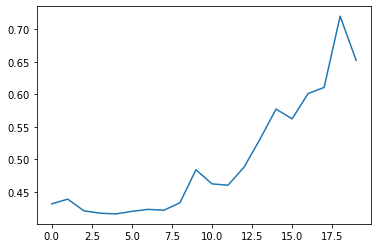

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])

In [31]:
# rebuild the same model to reset weights

x_seq = tf.keras.layers.Input(shape=(31, 1024), name='seq_input')

x1 = tf.keras.layers.Conv1D(256, 5, activation='relu')(x_seq)
x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)

x2 = tf.keras.layers.Conv1D(256, 4, activation='relu')(x_seq)
x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)

x3 = tf.keras.layers.Conv1D(256, 3, activation='relu')(x_seq)
x3 = tf.keras.layers.GlobalAveragePooling1D()(x3)

x = tf.keras.layers.Concatenate()([x1, x2, x3])

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

model = tf.keras.models.Model(inputs=[x_seq], outputs=y)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model.fit(x={'seq_input':seq_input}, y=output, epochs=7)

Epoch 1/7
238/238 [==============================] - 3s 12ms/step - loss: 0.4948 - accuracy: 0.7826
Epoch 2/7
238/238 [==============================] - 3s 11ms/step - loss: 0.4338 - accuracy: 0.8133
Epoch 3/7
238/238 [==============================] - 3s 11ms/step - loss: 0.4078 - accuracy: 0.8281
Epoch 4/7
238/238 [==============================] - 3s 11ms/step - loss: 0.3926 - accuracy: 0.8334
Epoch 5/7
238/238 [==============================] - 3s 11ms/step - loss: 0.3776 - accuracy: 0.8425
Epoch 6/7
238/238 [==============================] - 3s 11ms/step - loss: 0.3597 - accuracy: 0.8491
Epoch 7/7
238/238 [==============================] - 3s 11ms/step - loss: 0.3383 - accuracy: 0.8587


In [35]:
# Apply Preprocssing to Test Data

test_data = pd.read_csv('test.csv')

# test_data['text'] = test_data['text'].str.replace('http\S+', 'http', regex=True)
# test_data['text'] = test_data['text'].str.replace('&\S+', '', regex=True)
# test_data['text'] = test_data['text'].str.replace('[0-9]','0', regex=True)
# test_data['text'] = test_data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
# test_data['text'] = test_data['text'].str.lower()

# seq_input_test = lemmatize(test_data['text'])

# seq_input_test = elmo.get_elmo_vector_average(seq_input_test)

# with open('ELMo2/seq_input_test_elmo.pickle', 'wb') as file:
#     pickle.dump(seq_input_test, file)

with open('ELMo/seq_input_test_elmo.pickle', 'rb') as file:
    seq_input_test = pickle.load(file)

print("seq_input_test Shape: ", seq_input_test.shape)

seq_input_test Shape:  (3263, 31, 1024)


In [36]:
pred = model.predict(x={'seq_input':seq_input_test})
pred = np.asarray(np.rint(pred), dtype=int)
pred[:10]

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [37]:
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['target'] = pred
submission.head(10)

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [38]:
submission.to_csv('submission4.csv', index=False)
# Accuracy Score : 0.82531